In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cudar-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

--2021-06-02 03:23:48--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb [following]
--2021-06-02 03:23:48--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?B-RQG6PSnd40caRnS0WCeWJjPeRMlqXvuQ-r3ZUeVbPWemfXg3B38sizuCWTc1YusVEvnkgmc7vCYjUdepTBcAhcVSPgMBI7x

In [ ]:
!sudo apt install python3.6
!update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.6 2
!update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.7 1
!python --version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.6 is already the newest version (3.6.9-1~18.04ubuntu1.4).
python3.6 set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 98 not upgraded.
update-alternatives: renaming python3 link from /usr/bin/python3 to /usr/local/bin/python3
update-alternatives: using /usr/bin/python3.6 to provide /usr/local/bin/python3 (python3) in auto mode
Python 3.6.9


In [ ]:
%tensorflow_version 1.x

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install -r setup/requirements.txt
!pip3 install -e .
!sh setup/setup.sh

/bin/bash: /usr/local/bin/pip3: /usr/bin/python3: bad interpreter: No such file or directory
/bin/bash: /usr/local/bin/pip3: /usr/bin/python3: bad interpreter: No such file or directory
sh: 0: Can't open setup/setup.sh


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
#os.chdir("/content/drive/MyDrive/HFNet/hfnet")
os.chdir("/content/drive/Shareddrives/1397241734.HK(CRN.NGO)/hfnet-master")

In [ ]:
import cv2
import numpy as np
from pathlib import Path

#from hfnet.settings import EXPER_PATH
EXPER_PATH="/content/drive/Shareddrives/1397241734.HK(CRN.NGO)/hfnet-master/dataset/EXPER_PATH"
from notebooks.utils import plot_images, plot_matches, add_frame


import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Load query (night) and database (day) images

In [ ]:
query_idx = 1 # also try with 2 and 3
read_image = lambda n: cv2.imread('doc/tianjie4F/' + n)[:, :, ::-1]
images_db = [read_image(f'db{i}.jpg') for i in range(1, 17)]
image_query = read_image(f'query{query_idx}.jpg')
image_map = read_image(f'map.jpg')

plot_images([image_query] + images_db + [image_map], dpi=50)

Output hidden; open in https://colab.research.google.com to view.

# Create HF-Net model for inference

In [ ]:
EXPER_PATH="/content/drive/Shareddrives/1397241734.HK(CRN.NGO)/hfnet-master/dataset/EXPER_PATH/"
tf.reset_default_graph()
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        #tf.reset_default_graph()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')
        
    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

model_path = Path(EXPER_PATH, 'saved_models/hfnet')
outputs = ['global_descriptor', 'keypoints', 'local_descriptors']
hfnet = HFNet(model_path, outputs)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /content/drive/Shareddrives/1397241734.HK(CRN.NGO)/hfnet-master/dataset/EXPER_PATH/saved_models/hfnet/variables/variables


KeyError: ignored

# Compute global descriptors and local features for query and database

In [ ]:

db = [hfnet.inference(i) for i in images_db]
global_index = np.stack([d['global_descriptor'] for d in db])
query = hfnet.inference(image_query)

# Perform a global search in the database

In [ ]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

In [ ]:
nearest = np.argmin(compute_distance(query['global_descriptor'], global_index))
nearest_location = np.load('doc/tianjie4F/location.npy')
return_location = cv2.circle(image_map,(int(nearest_location[nearest][0]),int(nearest_location[nearest][1])),10,(255,0,0),-1)

disp_db = [add_frame(im, (0, 255, 0)) if i == nearest else im
           for i, im in enumerate(images_db)]
plot_images([image_query] + disp_db, dpi=50)


Output hidden; open in https://colab.research.google.com to view.

# Perform local matching with the retrieved image

In [ ]:
def match_with_ratio_test(desc1, desc2, thresh):
    dist = compute_distance(desc1, desc2)
    nearest = np.argpartition(dist, 2, axis=-1)[:, :2]
    dist_nearest = np.take_along_axis(dist, nearest, axis=-1)
    valid_mask = dist_nearest[:, 0] <= (thresh**2)*dist_nearest[:, 1]
    matches = np.stack([np.where(valid_mask)[0], nearest[valid_mask][:, 0]], 1)
    return matches

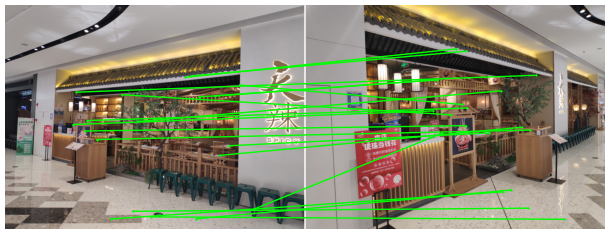

In [ ]:
matches = match_with_ratio_test(query['local_descriptors'],db[nearest]['local_descriptors'], 0.8)

plot_matches(image_query, query['keypoints'],
             images_db[nearest], db[nearest]['keypoints'],
             matches, color=(0, 1, 0), dpi=50)

# App Display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Please input your query image index: 
1
INFO:tensorflow:Restoring parameters from /content/drive/Shareddrives/1397241734.HK(CRN.NGO)/dataset/EXPER_PATH/saved_models/hfnet/variables/variables


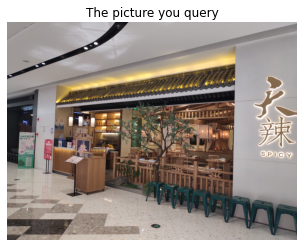

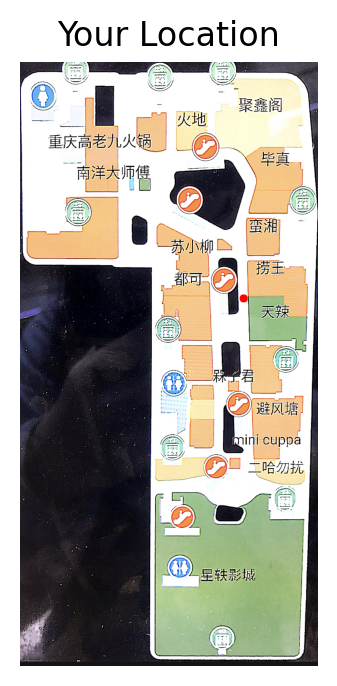

In [ ]:
import os
os.chdir("/content/drive/Shareddrives/1397241734.HK(CRN.NGO)/hfnet-master")

import cv2
import numpy as np
from pathlib import Path
from notebooks.utils import plot_images, plot_matches, add_frame
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op

%load_ext autoreload
%autoreload 2
%matplotlib inline

#加载图片（数据库）
print ("Please input your query image index: ")
query_idx = input() # also try with 2 and 3
read_image = lambda n: cv2.imread('doc/tianjie4F/' + n)[:, :, ::-1]
images_db = [read_image(f'db{i}.jpg') for i in range(1, 17)]
image_query = read_image(f'query{query_idx}.jpg')
image_map = read_image(f'map.jpg')

#加载HF-net
EXPER_PATH="/content/drive/Shareddrives/1397241734.HK(CRN.NGO)/dataset/EXPER_PATH/"
tf.reset_default_graph()
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        #tf.reset_default_graph()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')
        
    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

model_path = Path(EXPER_PATH, 'saved_models/hfnet')
outputs = ['global_descriptor', 'keypoints', 'local_descriptors']
hfnet = HFNet(model_path, outputs)

#Compute global descriptors and local features for query and database
db = [hfnet.inference(i) for i in images_db]
global_index = np.stack([d['global_descriptor'] for d in db])
query = hfnet.inference(image_query)

#Perform a global search in the database
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

nearest = np.argmin(compute_distance(query['global_descriptor'], global_index))
nearest_location = np.load('doc/tianjie4F/location.npy')
return_location = cv2.circle(image_map,(int(nearest_location[nearest][0]),int(nearest_location[nearest][1])),10,(255,0,0),-1)

def match_with_ratio_test(desc1, desc2, thresh):
    dist = compute_distance(desc1, desc2)
    nearest = np.argpartition(dist, 2, axis=-1)[:, :2]
    dist_nearest = np.take_along_axis(dist, nearest, axis=-1)
    valid_mask = dist_nearest[:, 0] <= (thresh**2)*dist_nearest[:, 1]
    matches = np.stack([np.where(valid_mask)[0], nearest[valid_mask][:, 0]], 1)
    return matches

#显示查询结果
import matplotlib.pyplot as plt                        
return_location = return_location.get()
#print("The picture you query: \n")
##plot_images([image_query],dpi=50)
#print("The match picture: \n")
#matches = match_with_ratio_test(query['local_descriptors'],db[nearest]['local_descriptors'], 0.8)

#plot_matches(image_query, query['keypoints'],
#             images_db[nearest], db[nearest]['keypoints'],
#             matches, color=(0, 1, 0), dpi=50)
#print("Your location: \n")

plt.imshow(image_query)
plt.axis('off')
plt.title('The picture you query')
plt.figure(dpi=200)
plt.imshow(return_location)
plt.axis('off') # 不显示坐标轴
plt.title('Your Location')
plt.show()

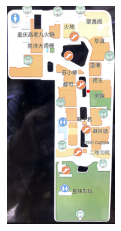

In [ ]:
import matplotlib.image as mp
plt.imshow(return_location) #该函数负责对图像进行处理，并显示其格式，但不能显示，其后跟着plt.show()才能显示出来
plt.axis('off') #不显示坐标轴
plt.show()
mp.imsave('yourlocation.jpg',return_location)